# Molecular dynamics from NN potentials

## 1. Datset with energy and forces

In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


Number of steps 100000


In [3]:
dataset.rename_property_on_graphs(old_property_name="energies", new_property_name="energy")
dataset.rename_property_on_graphs(old_property_name="forces", new_property_name="force")
dataset.rename_property_on_graphs(old_property_name="nuclear_charges", new_property_name="atomic_number")
dataset.rename_property_on_graphs(old_property_name="coords", new_property_name="node_coordinates")
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="node_coordinates")
data.map_list(method="count_nodes_and_edges", total_edges="total_ranges", count_edges="range_indices", 
    count_nodes="atomic_number", total_nodes="total_nodes")
data[0].keys()

dict_keys(['old_indices', 'old_energies', 'old_forces', 'energy', 'force', 'atomic_number', 'node_coordinates', 'range_indices', 'range_attributes', 'total_nodes', 'total_ranges'])

In [4]:
eng = np.array(data.get("energy"))*0.043  # kcal/mol to eV
eng.shape, eng[0]

((500, 1), array([-17469.90164208]))

In [5]:
forces = data.tensor({"name": "force", "shape": (None, 3)})*0.043  # kcal/mol to eV
atoms = data.get("atomic_number")
forces[0]

array([[-2.74137341,  2.67700611, -0.75129579],
       [-0.90631249, -0.85888416,  2.00726686],
       [ 3.08056969, -2.19163918, -0.22727128],
       [-0.37739256,  1.81854455, -0.04203819],
       [ 0.06849278,  1.909797  ,  0.88471585],
       [-0.57261954,  0.14867004, -0.18995724],
       [ 0.22410948,  0.77632092, -2.1626258 ],
       [-0.33297714, -1.23917868, -0.10066419],
       [ 0.52634416,  3.8645722 ,  2.08451895],
       [-0.72435461,  1.99949058,  0.7122311 ],
       [ 1.25228829, -1.18763783,  0.57869244],
       [ 0.61277482, -3.80501328, -2.03832495],
       [ 1.67075583, -0.99873548, -0.52365172],
       [-0.30834985, -0.53698349,  0.41058368],
       [ 1.24551168, -1.9163207 ,  1.40335446],
       [ 0.13337422,  0.1260334 , -0.94909162],
       [-1.12054561,  0.36520689, -0.17419492],
       [-0.46182796,  0.5091511 , -0.24017999],
       [-0.29275676, -1.11448041, -0.71522209],
       [-0.47046873,  0.30675033, -0.52878298],
       [-0.50524218, -0.65266984,  0.561

In [6]:
from kgcnn.data.transform.scaler.force import EnergyForceExtensiveLabelScaler
scaler = EnergyForceExtensiveLabelScaler(standardize_coordinates=False, standardize_scale=False)  # For testing no scale.
eng, _ = scaler.fit_transform(X=None, y=eng, force=forces, atomic_number=atoms)
eng[:3]

array([[-0.09150233],
       [ 0.09685228],
       [-0.32295041]])

## 2. `EnergyForceModel` container

In [7]:
from kgcnn.models.force import EnergyForceModel

In [8]:
model_config = {
    "name": "Schnet",
    "coordinate_input": 1,
    "inputs": [
        {"shape": [None], "name": "node_number", "dtype": "int32"},
        {"shape": [None, 3], "name": "node_coordinates", "dtype": "float32"},
        {"shape": [None, 2], "name": "range_indices", "dtype": "int64"},
        {"shape": (), "name": "total_nodes", "dtype": "int64"},
        {"shape": (), "name": "total_ranges", "dtype": "int64"}
    ],
    "nested_model_config": True,
    "output_to_tensor": True,
    "output_squeeze_states": True,
    "model_energy": {
        "class_name": "make_model",
        "module_name": "kgcnn.literature.Schnet",
        "config": {
            "name": "Schnet",
            "inputs": [
                {"shape": [None], "name": "atomic_number", "dtype": "int32"},
                {"shape": [None, 3], "name": "node_coordinates", "dtype": "float32"},
                {"shape": [None, 2], "name": "range_indices", "dtype": "int64"},
                {"shape": (), "name": "total_nodes", "dtype": "int64"},
                {"shape": (), "name": "total_ranges", "dtype": "int64"}
            ],
            "cast_disjoint_kwargs": {"padded_disjoint": False},
            "input_node_embedding": {"input_dim": 95, "output_dim": 64},
            "last_mlp": {"use_bias": [True, True, True], "units": [128, 64, 1],
                         "activation": [
                             {"class_name": "function", "config": "kgcnn>shifted_softplus"}, 
                             {"class_name": "function", "config": "kgcnn>shifted_softplus"}, 
                             'linear'
                         ]},
            "interaction_args": {
                "units": 128, "use_bias": True, 
                "activation": {"class_name": "function", "config": "kgcnn>shifted_softplus"},
                "cfconv_pool": "scatter_sum"
            },
            "node_pooling_args": {"pooling_method": "scatter_sum"},
            "depth": 4,
            "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4}, "verbose": 10,
            "output_embedding": "graph",
            "use_output_mlp": False,
            "output_mlp": None
        }
    },
    "outputs": {"energy": {"name": "energy", "shape": (1,)},
                "forces": {"name": "force", "shape": (None, 3)}}

}
model = EnergyForceModel(**model_config)

INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'Schnet', 'inputs': [{'shape': [None], 'name': 'atomic_number', 'dtype': 'int32'}, {'shape': [None, 3], 'name': 'node_coordinates', 'dtype': 'float32'}, {'shape': [None, 2], 'name': 'range_indices', 'dtype': 'int64'}, {'shape': (), 'name': 'total_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'total_ranges', 'dtype': 'int64'}], 'input_tensor_type': 'padded', 'input_embedding': None, 'cast_disjoint_kwargs': {'padded_disjoint': False}, 'input_node_embedding': {'input_dim': 95, 'output_dim': 64}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': {'class_name': 'function', 'config': 'kgcnn>shifted_softplus'}, 'cfconv_pool': 'scatter_sum'}, 'node_pooling_args': {'pooling_method': 'scatter_sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': [True, True, True], 'units': [128, 64, 1], 'activatio

In [9]:
x_tensor = data.tensor(model_config["model_energy"]["config"]["inputs"])
print([x.shape for x in x_tensor])

[(500, 21), (500, 21, 3), (500, 232, 2), (500,), (500,)]


In [10]:
test_out = model.predict(x_tensor)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [11]:
[i.shape for i in test_out.values()]

[(500, 1), (500, 21, 3)]

In [12]:
from keras.optimizers import Adam

In [13]:
model.compile(
    loss={"energy": "mean_absolute_error", "force": "mean_absolute_error"},
    optimizer=Adam(learning_rate=5e-04),
    metrics=None,
    loss_weights={"energy":1.0, "force":20.0},
)

In [14]:
model.predict(x_tensor, batch_size=2, steps=2)
model._compile_loss.build({"energy": eng, "force": forces}, {"energy": eng, "force": forces})

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [15]:
hist = model.fit(
    x_tensor, {"energy": eng, "force": forces},
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=0,
)

Epoch 1294/1500
8/8 - 1s - loss: 1.8698 - energy_loss: 0.3706 - force_loss: 0.0750 - 610ms/epoch - 76ms/step
Epoch 1295/1500
8/8 - 1s - loss: 1.8268 - energy_loss: 0.2774 - force_loss: 0.0775 - 645ms/epoch - 81ms/step
Epoch 1296/1500
8/8 - 1s - loss: 1.7237 - energy_loss: 0.3004 - force_loss: 0.0712 - 611ms/epoch - 76ms/step
Epoch 1297/1500
8/8 - 1s - loss: 1.7796 - energy_loss: 0.3744 - force_loss: 0.0703 - 603ms/epoch - 75ms/step
Epoch 1298/1500
8/8 - 1s - loss: 1.6922 - energy_loss: 0.2727 - force_loss: 0.0710 - 598ms/epoch - 75ms/step
Epoch 1299/1500
8/8 - 1s - loss: 1.7245 - energy_loss: 0.2860 - force_loss: 0.0719 - 614ms/epoch - 77ms/step
Epoch 1300/1500
8/8 - 1s - loss: 1.8538 - energy_loss: 0.2733 - force_loss: 0.0790 - 618ms/epoch - 77ms/step
Epoch 1301/1500
8/8 - 1s - loss: 1.9914 - energy_loss: 0.3206 - force_loss: 0.0835 - 652ms/epoch - 81ms/step
Epoch 1302/1500
8/8 - 1s - loss: 2.0053 - energy_loss: 0.3555 - force_loss: 0.0825 - 633ms/epoch - 79ms/step
Epoch 1303/1500
8/8

Epoch 1370/1500
8/8 - 1s - loss: 1.7885 - energy_loss: 0.3029 - force_loss: 0.0743 - 584ms/epoch - 73ms/step
Epoch 1371/1500
8/8 - 1s - loss: 1.8967 - energy_loss: 0.3072 - force_loss: 0.0795 - 579ms/epoch - 72ms/step
Epoch 1372/1500
8/8 - 1s - loss: 1.7590 - energy_loss: 0.3019 - force_loss: 0.0729 - 668ms/epoch - 83ms/step
Epoch 1373/1500
8/8 - 1s - loss: 1.7160 - energy_loss: 0.3050 - force_loss: 0.0706 - 657ms/epoch - 82ms/step
Epoch 1374/1500
8/8 - 1s - loss: 1.7361 - energy_loss: 0.2934 - force_loss: 0.0721 - 631ms/epoch - 79ms/step
Epoch 1375/1500
8/8 - 1s - loss: 1.7108 - energy_loss: 0.3144 - force_loss: 0.0698 - 656ms/epoch - 82ms/step
Epoch 1376/1500
8/8 - 1s - loss: 1.7204 - energy_loss: 0.2977 - force_loss: 0.0711 - 671ms/epoch - 84ms/step
Epoch 1377/1500
8/8 - 1s - loss: 1.7563 - energy_loss: 0.2909 - force_loss: 0.0733 - 668ms/epoch - 84ms/step
Epoch 1378/1500
8/8 - 1s - loss: 1.6346 - energy_loss: 0.2272 - force_loss: 0.0704 - 677ms/epoch - 85ms/step
Epoch 1379/1500
8/8

Epoch 1446/1500
8/8 - 1s - loss: 1.7595 - energy_loss: 0.3143 - force_loss: 0.0723 - 668ms/epoch - 83ms/step
Epoch 1447/1500
8/8 - 1s - loss: 1.7839 - energy_loss: 0.2968 - force_loss: 0.0744 - 637ms/epoch - 80ms/step
Epoch 1448/1500
8/8 - 1s - loss: 1.8501 - energy_loss: 0.3171 - force_loss: 0.0766 - 607ms/epoch - 76ms/step
Epoch 1449/1500
8/8 - 1s - loss: 1.8423 - energy_loss: 0.3111 - force_loss: 0.0766 - 599ms/epoch - 75ms/step
Epoch 1450/1500
8/8 - 1s - loss: 1.7719 - energy_loss: 0.3149 - force_loss: 0.0729 - 590ms/epoch - 74ms/step
Epoch 1451/1500
8/8 - 1s - loss: 1.6898 - energy_loss: 0.3050 - force_loss: 0.0692 - 605ms/epoch - 76ms/step
Epoch 1452/1500
8/8 - 1s - loss: 1.7285 - energy_loss: 0.3019 - force_loss: 0.0713 - 587ms/epoch - 73ms/step
Epoch 1453/1500
8/8 - 1s - loss: 1.7353 - energy_loss: 0.2921 - force_loss: 0.0722 - 631ms/epoch - 79ms/step
Epoch 1454/1500
8/8 - 1s - loss: 1.7460 - energy_loss: 0.2918 - force_loss: 0.0727 - 610ms/epoch - 76ms/step
Epoch 1455/1500
8/8

In [16]:
from kgcnn.utils.plots import plot_train_test_loss

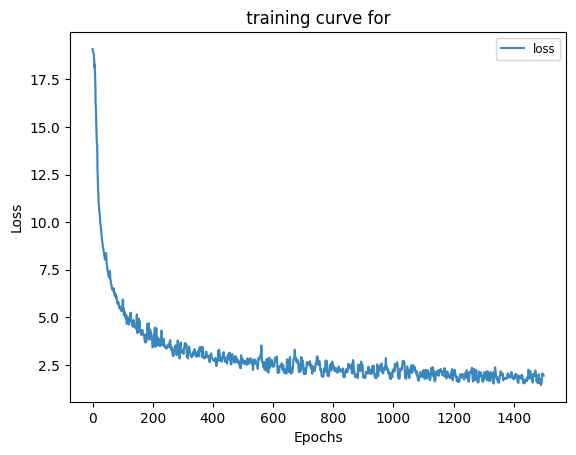

In [17]:
plot_train_test_loss([hist]);

## 3. `MolDynamicsModelPredictor` wrapping pre- and postprocessing

In [18]:
from kgcnn.molecule.dynamics.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor
from kgcnn.graph.preprocessor import SetRange, CountNodesAndEdges

In [19]:
dyn_model = MolDynamicsModelPredictor(
    model=model, 
    model_inputs=model_config["model_energy"]["config"]["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[
        SetRange(node_coordinates="node_coordinates", overwrite=False), 
        CountNodesAndEdges(total_edges="total_ranges", count_edges="range_indices", count_nodes="atomic_number", total_nodes="total_nodes")
    ],  # To use 
    graph_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, energy="energy", force="forces", atomic_number="atomic_number")],
    store_last_input=True,
    update_from_last_input=["range_indices"],  # and "range_images" if periodic.
    update_from_last_input_skip=3,
    use_predict=True
)

In [20]:
dyn_model(dataset[0:510])[0]

{'energy': array([-17469.83828173]),
 'forces': array([[-2.670555  ,  2.6772392 , -0.9047204 ],
        [-0.99556243, -0.8928257 ,  2.115237  ],
        [ 3.0201063 , -2.1920564 , -0.10269466],
        [-0.3934617 ,  1.6692059 , -0.10940111],
        [-0.0665977 ,  1.8290963 ,  0.9220997 ],
        [-0.6138771 ,  0.35973954, -0.12089539],
        [ 0.07644939,  0.7710326 , -2.137013  ],
        [-0.3606711 , -1.1926634 , -0.03478914],
        [ 0.6117526 ,  3.666739  ,  1.8770413 ],
        [-0.78135276,  1.9039568 ,  0.8194084 ],
        [ 1.1729598 , -1.1987687 ,  0.53568983],
        [ 0.52312624, -3.6745806 , -1.8835176 ],
        [ 2.1295605 , -1.0608826 , -0.69878817],
        [-0.2534858 , -0.50828743,  0.338701  ],
        [ 1.2685527 , -1.9717028 ,  1.4492956 ],
        [ 0.08581114,  0.35703838, -0.92711794],
        [-1.0106573 ,  0.34707612, -0.18868059],
        [-0.41618347,  0.49094236, -0.32614136],
        [-0.28099245, -1.0225637 , -0.6689911 ],
        [-0.503161  , 

## 4. Use ASE compatible `KgcnnSingleCalculator`

In [21]:
from ase import Atoms
from kgcnn.molecule.dynamics.ase_calc import KgcnnSingleCalculator, AtomsToGraphConverter

In [22]:
atoms = Atoms(dataset[0]["atomic_number"], positions=dataset[0]["node_coordinates"])
atoms

Atoms(symbols='C7O3C2OH8', pbc=False)

In [23]:
conv=AtomsToGraphConverter({"atomic_number": "get_atomic_numbers", "node_coordinates": "get_positions"})
conv(atoms)

<MemoryGraphList [{'atomic_number': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'node_coordinates': array([[ 2.15275078, -0.93790121, -0.05378575],
       [ 0.99956719,  1.13262738, -1.67300307],
       [ 2.73218273, -0.44859684, -1.19275553],
       [ 2.14794307,  0.41880283, -2.08405233],
       [-3.15705489,  1.42240939,  0.33067654],
       [ 0.91168856, -0.33727827,  0.29772754],
       [ 0.36105629,  0.72618343, -0.42339745],
       [-0.40166094, -0.12259909,  2.26219435],
       [-2.13128849, -0.48888369, -0.80224462],
       [ 0.29867456, -2.24990948,  1.44246368],
       [ 0.1239993 , -0.83296539,  1.42230211],
       [-2.04596577,  0.64616435, -0.22107209],
       [-0.88096468,  1.36265193, -0.06099633],
       [-0.02472582, -2.46371902,  2.33402192],
       [ 2.47956412, -1.70739289,  0.55101985],
       [ 0.49126967,  1.99943374, -2.09234064],
       [ 3.77819263, -0.85891833, -1.40897491],
       [ 2.75656656,  0.58901616, -2.98423316],
       [

In [24]:
calc = KgcnnSingleCalculator(model_predictor=dyn_model, atoms_converter=conv)
calc

In [25]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

In [26]:
atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

{'energy': array(-17469.83828191), 'forces': array([[-2.6705542 ,  2.6772387 , -0.9047214 ],
       [-0.9955634 , -0.8928251 ,  2.1152375 ],
       [ 3.0201075 , -2.192057  , -0.10269532],
       [-0.39346123,  1.6692051 , -0.10939991],
       [-0.06659603,  1.8290954 ,  0.92209923],
       [-0.6138769 ,  0.35974014, -0.12089533],
       [ 0.07644919,  0.77103245, -2.1370127 ],
       [-0.36067158, -1.1926638 , -0.03478879],
       [ 0.61175245,  3.6667366 ,  1.8770401 ],
       [-0.7813537 ,  1.9039577 ,  0.8194096 ],
       [ 1.1729604 , -1.1987686 ,  0.5356884 ],
       [ 0.5231255 , -3.6745777 , -1.8835161 ],
       [ 2.12956   , -1.0608817 , -0.69878805],
       [-0.25348562, -0.50828815,  0.338701  ],
       [ 1.2685529 , -1.9717036 ,  1.4492959 ],
       [ 0.08581102,  0.35703826, -0.9271178 ],
       [-1.0106578 ,  0.34707642, -0.1886805 ],
       [-0.41618264,  0.49094242, -0.3261423 ],
       [-0.28099155, -1.0225631 , -0.6689911 ],
       [-0.5031617 ,  0.32071868, -0.551135

In [27]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -831.897eV  Ekin = 0.052eV (T=399K)  Etot = -831.846eV
Energy per atom: Epot = -831.892eV  Ekin = 0.051eV (T=392K)  Etot = -831.841eV
Energy per atom: Epot = -831.918eV  Ekin = 0.074eV (T=569K)  Etot = -831.844eV
Energy per atom: Epot = -831.913eV  Ekin = 0.068eV (T=524K)  Etot = -831.845eV
Energy per atom: Epot = -831.896eV  Ekin = 0.056eV (T=437K)  Etot = -831.839eV
Energy per atom: Epot = -831.908eV  Ekin = 0.072eV (T=560K)  Etot = -831.836eV
Energy per atom: Epot = -831.908eV  Ekin = 0.068eV (T=525K)  Etot = -831.840eV
Energy per atom: Epot = -831.914eV  Ekin = 0.070eV (T=541K)  Etot = -831.844eV
Energy per atom: Epot = -831.904eV  Ekin = 0.067eV (T=518K)  Etot = -831.837eV
Energy per atom: Epot = -831.900eV  Ekin = 0.063eV (T=491K)  Etot = -831.837eV
Energy per atom: Epot = -831.901eV  Ekin = 0.057eV (T=442K)  Etot = -831.844eV
Energy per atom: Epot = -831.906eV  Ekin = 0.063eV (T=489K)  Etot = -831.843eV
Energy per atom: Epot = -831.903eV  Ekin = 0.065eV (

In [28]:
calc.model_predictor._last_input;

In [29]:
dyn_model._test_timing(conv(atoms))

0.018125